# Background
You are working for an insurance company in Wakanda. The company provides
health and term life insurance products. The company has compiled the data of
5,500 insurees into the file insurance_data.csv, to understand whether they renew
their policies with the company or not. You can find the description of the data in the
table below.

# Task 1: You have to create a prediction model to understand insuree renewal behaviour.
Create a presentation/Jupyter notebook to highlight salient features of the data and model results.

# Guiding Questions
What is the data quality and which steps did you take to clean and structure the
dataset (e.g., how did you handle outliers, missing values, etc.)? <br/>
For validation purposes the company would like to see some typical cross sections
of the data. For example, think of the following:
1. What is the average number of riders health insurance customers purchase,
and which ones are the most popular?
2. What is the most popular rider for older people?
3. Which model did you use to gain insight into the insuree behaviour, and what
are the determining factors for choosing this model?
4. Why are the insurees not renewing and what are the most important factors?

# Assumptions
1. Commas are replaced by decimal points for monthlyPremium and totalPremium as they are supposed to be of type float.
2. 'no term life policy taken' and 'term life policy not taken' means insuree has no term life insurance
3. NA values will be replaced with integer 0 for healthRiders, assuming insurees left it blank because they have no riders on their health policies.


### Import libraries and dataset
---

In [38]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
#Import dataset
df = pd.read_csv("insurance_data.csv", delimiter=';')

## Data Wrangling
---

### Data Cleaning - Preliminary check of data type and content of each column

In [40]:
#Preliminary check of each column's data type and values
for col in df.columns:
    print(df[col].dtype, col, df[col].sort_values().unique()[:10])

int64 insuree# [ 1  2  3  4  5  6  7  8  9 10]
object gender ['F' 'M' nan]
float64 is45OrOlder [ 0.  1. nan]
object isMarried ['No' 'Yes']
object hasKids ['No' 'Yes']
int64 insuredMonths [0 1 2 3 4 5 6 7 8 9]
object termLifeInsurance ['No' 'Yes']
object multipleTermLifePolicies ['No' 'Yes' 'no term life policy taken' 'term life policy not taken']
object healthInsurance ['Class A' 'Class B' 'No']
object healthRiders ['1' '1,2' '1,2,3' '1,2,3,4' '1,2,4' '1,3' '1,3,4' '1,4' '2' '2,3']
float64 premiumFrequency [ 1.  3. 12. nan]
object eStatements ['No' 'Yes']
object monthlyPremium ['100' '100,05' '100,1' '100,15' '100,2' '100,25' '100,3' '100,35' '100,4'
 '100,45']
object totalPremium [' ' '100,2' '100,25' '100,35' '100,8' '100,9' '1001,2' '1001,5' '1004,35'
 '1004,5']
object renewal ['N' 'Y']


### Data Cleaning - Fix content of each column

Boolean columns change to 1, 0 for standardization and easier data visualization later on

In [41]:
#Fix columns with Yes, No to change to 1, 0
df['is45OrOlder'] = df['is45OrOlder'].replace({'Yes':1, 'No':0})
df['isMarried'] = df['isMarried'].replace({'Yes':1, 'No':0})
df['hasKids'] = df['hasKids'].replace({'Yes':1, 'No':0})
df['termLifeInsurance'] = df['termLifeInsurance'].replace({'Yes':1, 'No':0})
df['eStatements'] = df['eStatements'].replace({'Yes':1, 'No':0})
df['renewal'] = df['renewal'].replace({'Yes':1, 'No':0})

#Create isMale column as proxy for gender for binary standardization
df['isMale'] =np.where(df['gender'] == 'M', 1, 0)

#Fix multipleTermLifePolicies column - Only Yes or No (change to 1, 0)
df['multipleTermLifePolicies'] = df['multipleTermLifePolicies'].replace(['no term life policy taken', 'term life policy not taken'], 'No')
df['multipleTermLifePolicies'] = df['multipleTermLifePolicies'].replace({'Yes':1, 'No':0})

#Fix healthInsurance column - Only Yes or No (change to 1, 0)
df['healthInsurance'] = df['healthInsurance'].replace(['Class A', 'Class B'], 'Yes')
df['healthInsurance'] = df['healthInsurance'].replace({'Yes':1, 'No':0})

#Fix monthlyPremium, totalPremium - comma replaced by decimal point for float type
df['monthlyPremium'] = df['monthlyPremium'].str.replace(',', '.')
df['totalPremium'] = df['totalPremium'].str.replace(',', '.')

#Fix totalPremium - remove empty string
df.loc[df.totalPremium == ' ', 'totalPremium'].count() #small number (9) of rows with empty string
df['totalPremium'] = df['totalPremium'].replace(' ', np.nan)
df.dropna(subset=['totalPremium'], inplace=True)

#Fix renewal - change Y, N to 1, 0 for standardization
df['renewal'] = df['renewal'].replace({'Y':1, 'N':0})

### Data Cleaning - NAs

#### Steps taken to treat NA values:
1. Find columns with NA values
2. If number of NA values is insignificant, will remove rows with NA values - removal of rows won't affect result much
3. If number of NA values is significant, will replace with a proper value based on context of question

#### Results:
1. NA values will be removed for columns: gender, is45OrOlder, premiumFrequency because total % of NA removed is only 5.87% (insignificant). Therefore, sufficient data is still available for training prediction model
2. NA values will be replaced with integer 0 for column: healthRiders. Since the amount of missing values are too significant, it can be assumed that the missing values are intentional - maybe due to some miscommunication when insurees were asked to answer the questions. Hence, it is possible that insurees did not fill in the data for healthRiders because they have zero riders on their health plans and intentionally left it blank.

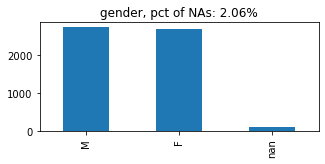

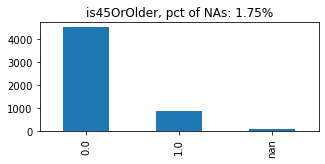

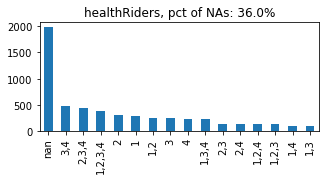

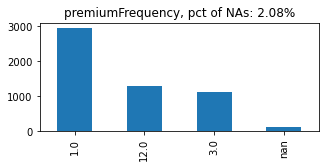

In [42]:
#Check NA values for each columns - has problems: gender, is45OrOlder, healthRiders, premiumFrequency
df.isna().sum()

#Preliminary data exploration to check each NA columns individually
for col in df.columns[df.isna().any()].tolist():
    count_NA = df[col].isna().sum()
    pct_NA = round(count_NA*100/df.shape[0],2)
    fig = plt.figure(figsize=(5,2))
    df[col].value_counts(dropna=False).plot(kind='bar', title=f'{col}, pct of NAs: {pct_NA}%')

In [43]:
#Treat NA values

#Remove NA values for gender, is45OrOlder, premiumFrequency - total rows removed is only ~6% of dataset
df.dropna(subset=['gender', 'is45OrOlder', 'premiumFrequency'], inplace=True)

#Replace NA values with 0 for healthRiders - assume NA values are actually 0
df['healthRiders'].fillna(0, inplace=True)

#Final check
df.isna().sum()

insuree#                    0
gender                      0
is45OrOlder                 0
isMarried                   0
hasKids                     0
insuredMonths               0
termLifeInsurance           0
multipleTermLifePolicies    0
healthInsurance             0
healthRiders                0
premiumFrequency            0
eStatements                 0
monthlyPremium              0
totalPremium                0
renewal                     0
isMale                      0
dtype: int64

### Data Cleaning - Correcting data types of each column
Data types are changed for easier data manipulation and visualization later on

In [44]:
#Convert to correct data type
convert_dict = {
    'insuree#' : 'int64',
    'gender': str,
    'is45OrOlder': 'int64',
    'isMarried':'int64',
    'hasKids': 'int64',
    'insuredMonths': 'int64',
    'termLifeInsurance': 'int64',
    'multipleTermLifePolicies': 'int64',
    'healthInsurance': 'int64',
    'healthRiders': str,
    'premiumFrequency': 'int64',
    'eStatements': 'int64',
    'monthlyPremium': 'float64',
    'totalPremium': 'float64',
    'renewal': 'int64',
}

df = df.astype(convert_dict)
df.dtypes

insuree#                      int64
gender                       object
is45OrOlder                   int64
isMarried                     int64
hasKids                       int64
insuredMonths                 int64
termLifeInsurance             int64
multipleTermLifePolicies      int64
healthInsurance               int64
healthRiders                 object
premiumFrequency              int64
eStatements                   int64
monthlyPremium              float64
totalPremium                float64
renewal                       int64
isMale                        int32
dtype: object

### Data Cleaning - Outliers

#### Steps taken to treat outlier values:
1. Check outliers for columns with int/float data types
2. Use interquartile range rule to remove outliers

#### Results:
1. 5096 rows remain after removal (93% data retained) - still sufficient for training model

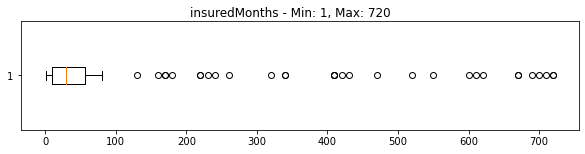

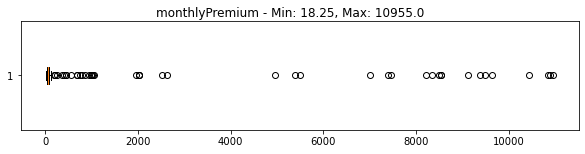

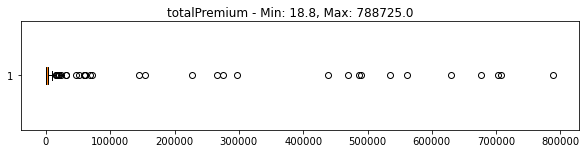

In [45]:
#Check outlier using boxplot for each int/float column:
for col in ['insuredMonths', 'monthlyPremium', 'totalPremium']:
    val_min, val_max = df[col].min(), df[col].max()
    fig = plt.figure(figsize=(10,2))
    plt.boxplot(df[col], vert=False)
    fig.suptitle(f'{col} - Min: {val_min}, Max: {val_max}')

(5096, 16)


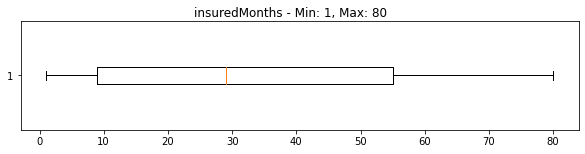

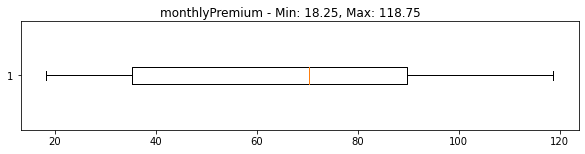

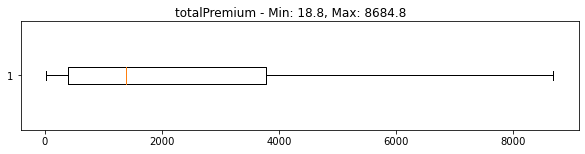

In [46]:
#Treat outliers using interquartile range
df_cleaned = df.copy()
index_list = []
for col in ['insuredMonths', 'monthlyPremium', 'totalPremium']:
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    upper_limit = df[col].quantile(0.75) + 1.5*IQR
    lower_limit = df[col].quantile(0.75) - 1.5*IQR
    df_cleaned = df_cleaned.loc[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

#Final check for outliers
print(df_cleaned.shape) #~7% data removed from orginal dataset
for col in ['insuredMonths', 'monthlyPremium', 'totalPremium']:
    val_min, val_max = df_cleaned[col].min(), df_cleaned[col].max()
    fig = plt.figure(figsize=(10,2))
    plt.boxplot(df_cleaned[col], vert=False)
    fig.suptitle(f'{col} - Min: {val_min}, Max: {val_max}')


### Data Exploration - Finding notable insights

1. What is the average number of riders health insurance customers purchase, and which ones are the most popular?
* Mean number of riders bought is 1.39
* The most popular rider is rider 4
2. What is the most popular rider for older people?
* The most popular rider for older people is also rider 4

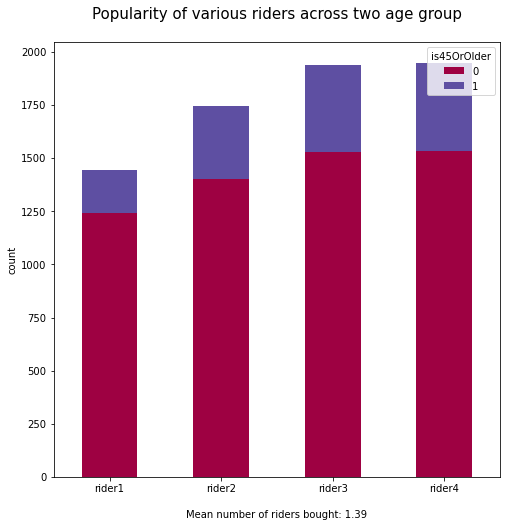

In [47]:
#Visualization
df_cleaned['rider1'] = np.where(df_cleaned.healthRiders.str.contains('1'), 1, 0)
df_cleaned['rider2'] = np.where(df_cleaned.healthRiders.str.contains('2'), 1, 0)
df_cleaned['rider3'] = np.where(df_cleaned.healthRiders.str.contains('3'), 1, 0)
df_cleaned['rider4'] = np.where(df_cleaned.healthRiders.str.contains('4'), 1, 0)
cols = ['rider1', 'rider2', 'rider3', 'rider4']
avg = df_cleaned[cols].sum().sum()/df_cleaned.shape[0]

cmap = plt.cm.Spectral
colors = cmap(np.linspace(0., 1., 2))

fig, ax = plt.subplots(figsize=(8,8))
df_cleaned.groupby('is45OrOlder')[cols].sum().T.plot(kind='bar', color=colors, rot=0, stacked=True, ax=ax)
plt.title('Popularity of various riders across two age group\n', fontsize = '15')
ax.set_xlabel(f'\nMean number of riders bought: {round(avg,2)}', fontsize = '10')
ax.set_ylabel('count', fontsize = '10')
plt.legend(loc='upper right', title='is45OrOlder')
plt.show()

1. What are the characteristics of insurees who have renewed their policies?

* Most of them are married
* Most of them are males
* Most of them only owns one term life policy
* Most of them also own a health insurance
* Most of them opted for e-statements and e-policies
* Overall, it seems like marriage, number and type of policies have more effect on insurees' renewal decision

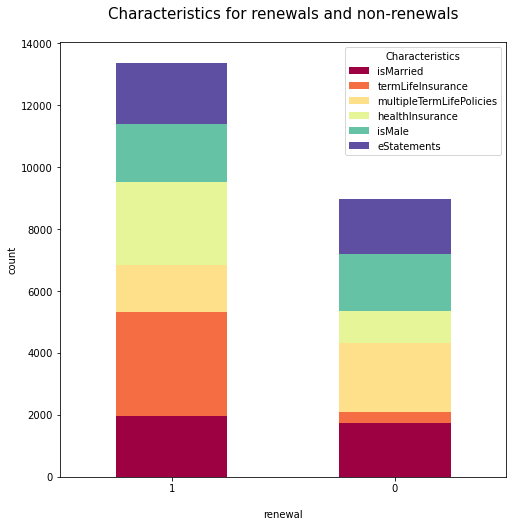

In [48]:
#Visualization
cols = ['isMarried', 'termLifeInsurance', 'multipleTermLifePolicies', 'healthInsurance', 'isMale', 'eStatements']

cmap = plt.cm.Spectral
colors = cmap(np.linspace(0., 1., len(cols)))

fig, ax = plt.subplots(figsize=(8,8))
df_cleaned.loc[df.renewal == 1, cols].apply(lambda x: x.value_counts()).sort_index(ascending=False).plot(kind='bar', color=colors, rot=0, stacked=True, ax=ax)
plt.title('Characteristics for renewals and non-renewals\n', fontsize = '15')
ax.set_xlabel('\nrenewal', fontsize = '10')
ax.set_ylabel('count', fontsize = '10')
plt.legend(loc='upper right', title='Characteristics')
plt.show()

1. How much do insurees spend on policy premiums?

* For those who renew their policies, most of them tend to fall on the lower and upper range of total and monthly premiums spent
* For those who did not renew their policies, they mostly fall on the lower range of monthly premiums spent
* Overall, it seems like the amount of premiums spent do not affect insurees' renewal decision

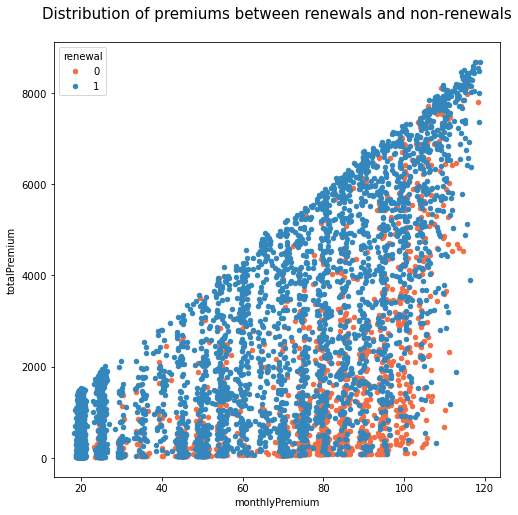

In [49]:
#Visualization
cols = ['monthlyPremium', 'totalPremium']

cmap = plt.cm.Spectral
colors = cmap(np.linspace(0.2, 0.9, 2))
colors = dict(enumerate(colors))

fig, ax = plt.subplots(figsize=(8,8))
for key, group in df_cleaned.groupby('renewal'):
    group.plot(ax=ax, kind='scatter', x='monthlyPremium', y='totalPremium', style='o',
    label=key, color=colors[key].reshape(1,-1), s=20)
plt.title('Distribution of premiums between renewals and non-renewals\n', fontsize = '15')
plt.legend(title='renewal')
plt.show()

## Preparing predictive model - Random Forest
---


### Which model did you use to gain insight into the insuree behaviour, and what are the determining factors for choosing this model?'

Random Forest is chosen because of the following model features:

1. It can handle both categorical and numerical features
2. Bagging helps to stabilize model performance by creating many decision trees trained on bootstrapped training sets and aggregating the results
3. Random Subset Feature Selection helps to reduce correlation between trees 
4. Variable importance can be visualized and relatively unimportant variables can be removed to further optimize model

### Data Preparation
* Changing to appropriate data types for training model
* Creating dummy columns for categorical data

In [56]:
#Use only relevant columns
df_cleaned = df_cleaned.drop(columns=['insuree#', 'gender', 'healthRiders'])

#Change data types
convert_dict = {
    'is45OrOlder': 'str',
    'isMarried':'str',
    'hasKids': 'str',
    'insuredMonths': 'int64',
    'termLifeInsurance': 'str',
    'multipleTermLifePolicies': 'str',
    'healthInsurance': 'str',
    'premiumFrequency': str,
    'eStatements': 'str',
    'monthlyPremium': 'float64',
    'totalPremium': 'float64',
    'renewal': 'str',
    'isMale': 'str',
    'rider1': 'str',
    'rider2': 'str',
    'rider3': 'str',
    'rider4': 'str',
}

df_cleaned = df_cleaned.astype(convert_dict)
df_cleaned.dtypes

#Create dummy columns for premiumFrequency
df_cleaned = pd.get_dummies(df_cleaned, columns=['premiumFrequency'], prefix_sep='')

### Train-test split

In [57]:
y_value = np.array(df_cleaned['renewal'])
df_features = df_cleaned.drop('renewal', axis=1)

#Train-test split
train_x, test_x, train_y, test_y = train_test_split(df_features, y_value, test_size = 0.3, random_state = 2022)

In [66]:
# Baseline accuracy - model performance must beat this baseline for model to be meaningful
baseline_accuracy = list(y_value).count('1')/len(list(y_value))
print(f'Model must have a accuracy higher than {round(baseline_accuracy*100,2)}%')

Model must have a accuracy higher than 73.02%


### Train and test model

Accuracy on training set: 99.75%
Accuracy on test set: 78.81%


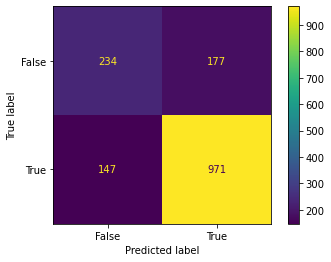

<Figure size 720x720 with 0 Axes>

In [59]:
#Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 2022)

#Train the model on training data
rf.fit(train_x, train_y)

#Use the forest's predict method on the test data
pred_y = rf.predict(test_x)

#Evaluate the model
print(f"Accuracy on training set: {round(rf.score(train_x, train_y)*100,2)}%")
print(f"Accuracy on test set: {round(rf.score(test_x, test_y)*100,2)}%")

#Visualize confusion matrix
cm = confusion_matrix(test_y, pred_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.figure(figsize=(10, 10))
plt.show()

### Feature importance - Which columns affect insurees' renewal decision

1. Why are the insurees not renewing and what are the most important factors?

* It seems like the two most important factor are monthly premium followed by total premium. This implies that the amount of premiums insurees pay highly affect whether they will want to renew their policies. This makes sense as expensive policies are harder to continuously fund for the average insuree.

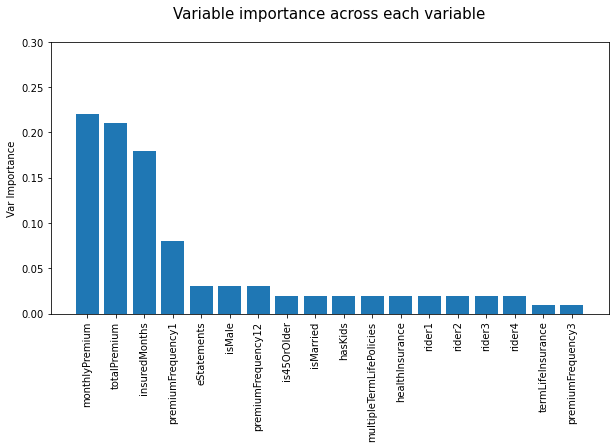

In [60]:
#Visualiz feature importance
var_importance = [(feature, round(importance, 2)) for feature, importance in zip(df_features.columns.tolist(), list(rf.feature_importances_))]
var_importance = sorted(var_importance, key = lambda x: x[1], reverse = True)
sorted_importances = [importance[1] for importance in var_importance]
sorted_features = [importance[0] for importance in var_importance]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(range(df_features.shape[1]), sorted_importances)
plt.xticks(range(df_features.shape[1]), sorted_features, rotation=90)
plt.title('Variable importance across each variable\n', fontsize = '15')
ax.set_ylabel('Var Importance')
plt.ylim(0, 0.3)
plt.show()

### Improving performance of model
Remove variables with relatively lower importance

Accuracy on training set: 99.75%
Accuracy on test set: 78.94%


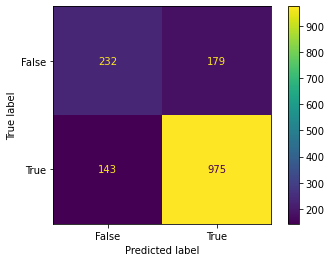

<Figure size 720x720 with 0 Axes>

In [70]:
y_value = np.array(df_cleaned['renewal'])
df_features = df_cleaned.drop(columns=['renewal','termLifeInsurance'])

#Train-test split
train_x, test_x, train_y, test_y = train_test_split(df_features, y_value, test_size = 0.3, random_state = 2022)

#Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators=1000, random_state=2022)

#Train the model on training data
rf.fit(train_x, train_y)

#Use the forest's predict method on the test data
pred_y = rf.predict(test_x)

#Evaluate the model
print(f"Accuracy on training set: {round(rf.score(train_x, train_y)*100,2)}%")
print(f"Accuracy on test set: {round(rf.score(test_x, test_y)*100,2)}%")

#Visualize confusion matrix
cm = confusion_matrix(test_y, pred_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.figure(figsize=(10, 10))
plt.show()